-visualize the metrics, confusion matrix, make jupyter notebook
  - load model
  - load generator
  - evaluate x images
  - calc metrics
    -by task and class, accuracy, precision, recall, specificty, f1 score, matthews coreelation coefficient, confusion matrix
  - write function that visualizes images, targets, and outputs
    - highlight errors
    - or only show outputs that have erros (100% accuracte labels not shown)


In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn  # Building the model
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchsummary import summary

from save_load import load_multitask_resnet
from dataset import LiveTargetDataset

In [2]:
# Load the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path = "runs/run0130_best_loss.pth"
model, input_size, mean, std = load_multitask_resnet(path, device)

mean = np.array(mean)
std = np.array(std)

print("input_size :", input_size)
print("mean :", mean)
print("std :", std)

input_size : 32
mean : [0.378 0.306 0.38 ]
std : [0.252 0.216 0.252]


In [3]:
# Load the generator
target_size = 30
scale = (1.0, 1.0)
rotation = True
expansion_factor = 4
val_size = 1000
batch_size = 1

In [4]:
val_transforms = T.Compose([
    T.Resize((input_size)),  # Make shortest edge this size
    T.CenterCrop(input_size),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

val_dataset = LiveTargetDataset(transforms=val_transforms, input_size=expansion_factor*input_size,
    target_size=expansion_factor*target_size, length=val_size, scale=scale, rotation=rotation)

val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

In [5]:
def labels_to_words(label):
    out = []
    out.append(int(label[0]))
    out.append(val_dataset.gen.shape_options[int(label[1])])
    out.append(val_dataset.gen.letter_options[int(label[2])])
    out.append(val_dataset.gen.color_options[int(label[3])])
    out.append(val_dataset.gen.color_options[int(label[4])])
    return out

In [6]:
print(val_dataset.gen.angle_quantization)
print(val_dataset.gen.shape_options)
print(val_dataset.gen.letter_options)
print(val_dataset.gen.color_options)
print(val_dataset.gen.color_options)

16
['star', 'circle', 'square', 'trapezoid', 'pentagon']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
['white', 'black', 'red', 'blue']
['white', 'black', 'red', 'blue']


In [7]:
# Pass all the validate data and store the predictions
tasks_preds = np.zeros((val_size, 5))
all_targets = np.zeros((val_size, 5))

for idx, (data, target) in enumerate(val_loader):
    all_targets[idx] = target.numpy()
    preds = model(data)
    for i in range(len(preds)):
        tasks_preds[idx][i] = torch.max(preds[i], dim=1)[1]
#     print("      target :", target.squeeze().long().tolist())
#     print(" tasks_preds :", tasks_preds[idx])


task 0 : tensor([ 0.6645, -0.8166, -0.6734,  0.4242,  0.3357,  0.0629, -0.7460, -0.8037,
         0.0822, -0.4252, -0.8207,  0.3226,  1.3613,  0.3081, -0.4526,  1.1738],
       grad_fn=<SqueezeBackward0>)
task 1 : tensor([-0.3996, -0.4290,  0.3380,  0.5940, -0.1861],
       grad_fn=<SqueezeBackward0>)
task 2 : tensor([-1.8241,  1.2782, -1.3129,  0.3028,  2.3335, -1.3406,  1.4580, -0.5184],
       grad_fn=<SqueezeBackward0>)
task 3 : tensor([-0.7860,  0.6621, -0.8390, -0.3762], grad_fn=<SqueezeBackward0>)
task 4 : tensor([ 0.7530, -0.1101, -0.6531, -0.4708], grad_fn=<SqueezeBackward0>)
target:  [12.  4.  5.  3.  2.]
 preds:  [12.  3.  4.  1.  0.]
target:  [12, 'pentagon', 'F', 'blue', 'red']
 preds:  [12, 'trapezoid', 'E', 'black', 'white']


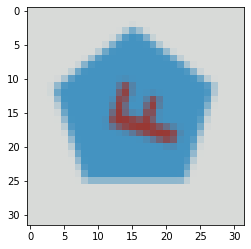

In [73]:
data, target = next(iter(val_loader))
preds = model(data)
preds_idx = np.zeros((5))
for i in range(len(preds)):
    preds_idx[i] = torch.max(preds[i], dim=1)[1]

for i in range(len(preds)):
    print(f"task {i} :", preds[i].squeeze())
print("target: ", target.squeeze().numpy())
print(" preds: ", preds_idx)
print("target: ", labels_to_words(target.squeeze().long().tolist()))
print(" preds: ", labels_to_words(preds_idx))

img = data.squeeze()
img = T.Normalize(-mean/std,1/std)(img)
img = img.permute(1,2,0) 
plt.imshow(img)
plt.show()

In [9]:
# Make the confusion matrices
conf_mats = [confusion_matrix(all_targets[:, i], tasks_preds[:, i]) for i in range(5)]

<AxesSubplot:>

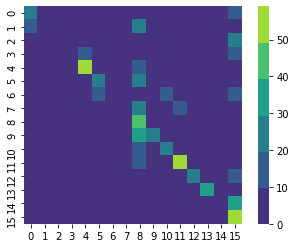

In [10]:
# Orientation Matrix
sn.heatmap(conf_mats[0], square=True,
#            cmap="RdYlGn",
           cmap=sn.color_palette("viridis")
    )

<AxesSubplot:>

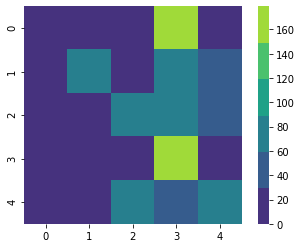

In [11]:
# Shape Matrix
sn.heatmap(conf_mats[1], square=True,
#            cmap="RdYlGn",
           cmap=sn.color_palette("viridis")
    )

<AxesSubplot:>

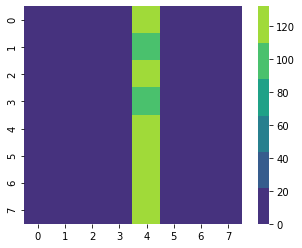

In [12]:
# Letter Matrix
sn.heatmap(conf_mats[2], square=True,
#            cmap="RdYlGn",
           cmap=sn.color_palette("viridis")
    )

<AxesSubplot:>

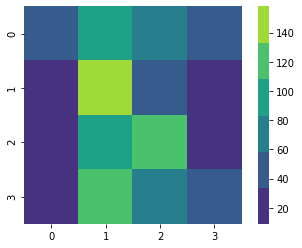

In [13]:
# Shape Color Matrix
sn.heatmap(conf_mats[3], square=True,
#            cmap="RdYlGn",
           cmap=sn.color_palette("viridis")
    )

<AxesSubplot:>

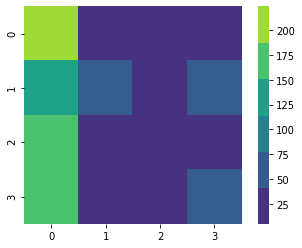

In [14]:
# Letter Color Matrix
sn.heatmap(conf_mats[4], square=True,
#            cmap="RdYlGn",
           cmap=sn.color_palette("viridis")
    )